In [1]:
import pandas as pd
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Normalize
from scipy.stats import skew

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import silhouette_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import root_mean_squared_error, r2_score


import seaborn as sns
import geopandas as gpd


## Define Colors and load dataset

In [6]:
colors = ["#4373c3","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

In [32]:
filename = "filtered_dataset.csv"
dataset = pd.read_csv(filename)
identifiers = ["Jahr", "Code", "Name"]
dataset.keys()

Index(['Jahr', 'Code', 'Name', 'Ausländer (m)', 'Ausländer (w)', 'Ausländer',
       'Einwohner (m)', 'Einwohner (w.)', 'Einwohner', '15-65, m', '15-65, w',
       'Beschäftigte (tot.)', 'mit akademischem Abschluss (tot.)',
       'mit anerkanntem Berufsabschluss (tot.)', 'ohne Berufsabschluss (tot.)',
       'Beschäftigte (ausl.)', 'mit akademischem Abschluss (ausl.)',
       'mit anerkanntem Berufsabschluss (ausl.)',
       'ohne Berufsabschluss (ausl.)', 'MSL (tot.)', 'SGB II (tot.)',
       'SGB II (erwerbsf.)', 'SGB II (n.erwerbsf.)', 'SGB XII (Lebensunt.)',
       'SGB XII (Grundsicher.)', 'Regelleist. (Asyl)', 'Altenquotient',
       'Erwerbstätige (tot.)', 'A', 'B-E', 'C', 'F', 'G-J', 'V', 'Ö', 'Fläche',
       'Einkommen (tot.)', 'Einkommen', 'Arbeitslose', 'Arbeitslose (ausl.)',
       'Arbeitslose (s.beh.)', 'Arbeitslose (15-20)', 'Arbeitslose (15-25)',
       'Arbeitslose (55-65)', 'langzeitarbeitslos',
       'Abendschulen und Kollegs (1995)', 'Freie Waldorfschulen (1995)'

In [12]:
gdf = gpd.read_file("VG2500_KRS.shp")
gdf['AGS'] = gdf['AGS'].astype(int)       # or 'AGS' if that’s the code column

/home/erisa/miniconda3/envs/IML/lib/python3.12/site-packages/pyogrio/geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)
/home/erisa/miniconda3/envs/IML/lib/python3.12/site-packages/pyogrio/geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)


## Normalize columns

Divide by Einwohnerzahl
- Ausländer --> Ausländeranteil 
- Ausländer (w.) --> Ausländeranteil (w.)
- Ausländer (m.) --> Ausländeranteil (m.)
- Arbeitslose --> Arbeitslosenanteil

Divide by 15-65, m + 15-65, w (tot. = w. + m.)
- Beschäftigte (tot.) --> Beschäftigtenanteil (tot.) (+ variations)
- Mindestsicherungsleistungen (tot.) --> Mindestsicherungsleistungsanteil (tot.) (+ variations)


Difference between Beschäftigte and Erwerbstätige:
- Here: Beschäftigte am Wohnort, Erwerbstätige am Arbeitsort
- Beschäftigte are covered by social insurance



In [3]:
Ausländer_keys = ['Ausländer (m)', 'Ausländer (w)', 'Ausländer']
Beschäftigte_keys = ['Beschäftigte (tot.)', 'mit akademischem Abschluss (tot.)',
       'mit anerkanntem Berufsabschluss (tot.)', 'ohne Berufsabschluss (tot.)',
       'Beschäftigte (ausl.)', 'mit akademischem Abschluss (ausl.)',
       'mit anerkanntem Berufsabschluss (ausl.)',
       'ohne Berufsabschluss (ausl.)']
MSL_keys = ['MSL (tot.)', 'SGB II (tot.)',
       'SGB II (erwerbsf.)', 'SGB II (n.erwerbsf.)', 'SGB XII (Lebensunt.)',
       'SGB XII (Grundsicher.)', 'Regelleist. (Asyl)']
Erwerbstätige_keys = ['Erwerbstätige (tot.)', 'A', 'B-E', 'C', 'F', 'G-J', 'V', 'Ö']
other_keys = ['Altenquotient', "Fläche"]
Arbeitslose_keys = ['Arbeitslose', 'Arbeitslose (ausl.)',
       'Arbeitslose (s.beh.)', 'Arbeitslose (15-20)', 'Arbeitslose (15-25)',
       'Arbeitslose (55-65)', 'langzeitarbeitslos']
Schulen2022_keys = ['Abendschulen und Kollegs (2022)', 'Freie Waldorfschulen (2022)',
       'Grundschulen (2022)', 'Gymnasien (2022)', 'Hauptschulen (2022)',
       'Integrierte Gesamtschulen (2022)', 'Realschulen (2022)',
       'Schularten mit mehreren Bildungsgängen (2022)',
       'Schulartunabhängige Orientierungsstufe (2022)',
       'Sonderschulen/ Förderschulen (2022)', 'Vorschulbereich (2022)']
Schulen1995_keys = ['Abendschulen und Kollegs (1995)', 'Freie Waldorfschulen (1995)',
       'Grundschulen (1995)', 'Gymnasien (1995)', 'Hauptschulen (1995)',
       'Integrierte Gesamtschulen (1995)', 'Realschulen (1995)',
       'Schularten mit mehreren Bildungsgängen (1995)',
       'Schulartunabhängige Orientierungsstufe (1995)',
       'Sonderschulen/ Förderschulen (1995)', 'Vorschulbereich (1995)']


### Normalize and create a dataset for the targets and one for the features 

Normalization is done by dividing through the number of inhabitants between 15 and 65 years old

In [13]:
df_norm = dataset[["Jahr", "Code", "Name"]].copy()
df_norm['Code'] = df_norm['Code'].astype(int)

for key in Ausländer_keys + Arbeitslose_keys + Schulen1995_keys:# + Schulen2022_keys:
    df_norm[key] = dataset[key] / dataset["Einwohner"]
for key in Beschäftigte_keys + MSL_keys + Erwerbstätige_keys:
    df_norm[key] = dataset[key] / (dataset["15-65, m"]+dataset["15-65, w"])

df_features = df_norm.copy()
df_norm['Einkommen'] = dataset['Einkommen'] 
df_target = df_norm[["Jahr", "Code", "Name", 'Einkommen']].copy()


In [61]:
df_norm

,Jahr,Code,Name,Ausländer (m),Ausländer (w),Ausländer,Arbeitslose,Arbeitslose (ausl.),Arbeitslose (s.beh.),Arbeitslose (15-20),...,Regelleist. (Asyl),Erwerbstätige (tot.),A,B-E,C,F,G-J,V,Ö,Einkommen
0,2013,1001,"Flensburg, kreisfreie Stadt",0.047266,0.042824,0.090091,0.061986,0.005907,0.003644,0.001465,...,0.004294,0.001013,0.000000e+00,0.000115,0.000099,0.000025,0.000300,0.000176,0.000397,17976.0
1,2013,1002,"Kiel, kreisfreie Stadt",0.042114,0.040723,0.082838,0.054113,0.008794,0.002070,0.000956,...,0.004370,0.000970,5.936832e-07,0.000091,0.000080,0.000027,0.000235,0.000195,0.000422,17894.0
2,2013,1003,"Lübeck, kreisfreie Stadt",0.042722,0.040623,0.083345,0.052165,0.008011,0.002404,0.001146,...,0.004290,0.000898,2.177447e-06,0.000120,0.000109,0.000039,0.000237,0.000173,0.000328,17925.0
3,2013,1004,"Neumünster, kreisfreie Stadt",0.038166,0.034247,0.072413,0.057866,0.008202,0.002647,0.001350,...,0.008469,0.000970,1.008247e-05,0.000127,0.000113,0.000052,0.000313,0.000171,0.000298,17392.0
4,2013,1051,"Dithmarschen, Landkreis",0.017902,0.017058,0.034960,0.037712,0.002201,0.001606,0.001161,...,0.004718,0.000689,4.169893e-05,0.000100,0.000089,0.000057,0.000179,0.000071,0.000238,19465.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,2022,16073,"Saalfeld-Rudolstadt, Landkreis",0.027473,0.024962,0.052434,0.028428,0.003899,0.002097,0.000758,...,0.004597,0.000754,1.361980e-05,0.000204,0.000187,0.000053,0.000140,0.000087,0.000257,23783.0
3896,2022,16074,Saale-Holzland-Kreis,0.026736,0.024045,0.050781,0.021449,0.002680,0.001352,0.000467,...,0.003239,0.000692,2.429396e-05,0.000178,0.000170,0.000063,0.000152,0.000089,0.000186,24137.0
3897,2022,16075,Saale-Orla-Kreis,0.031503,0.024744,0.056183,0.025203,0.002972,0.001671,0.000497,...,0.008446,0.000784,3.031812e-05,0.000266,0.000256,0.000069,0.000141,0.000069,0.000210,23631.0
3898,2022,16076,"Greiz, Landkreis",0.024454,0.019469,0.043870,0.023488,0.003369,0.001637,0.000441,...,0.008426,0.000698,2.037075e-05,0.000193,0.000176,0.000072,0.000169,0.000057,0.000185,24144.0


## Income Animation and Distribution

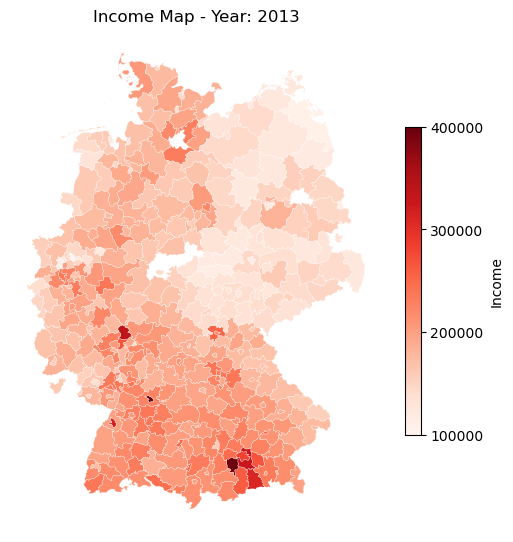

In [14]:
fig, ax = plt.subplots(figsize=(6, 8))

vmin, vmax = 100000, 400000  
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.Reds
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm._A = []  

cbar = fig.colorbar(sm, ax=ax, shrink=0.5, ticks=[1e5, 2e5, 3e5, 4e5])
cbar.set_label("Income")



def update(year):
    ax.clear()

    df_select = df_target[df_norm['Jahr'] == year].copy()
    geo_merged = gdf.merge(df_select, left_on='AGS', right_on='Code')

    geo_merged.plot(
        column='Einkommen',
        cmap="Reds",
        ax=ax,
        edgecolor='white',
        linewidth=0.2
    )

    ax.set_title(f"Income Map - Year: {year}")
    ax.axis('off')

anim = FuncAnimation(fig, update, frames=range(2013, 2023), interval=800, repeat=True)

anim.save('income_animation.gif', writer='pillow', fps=1)



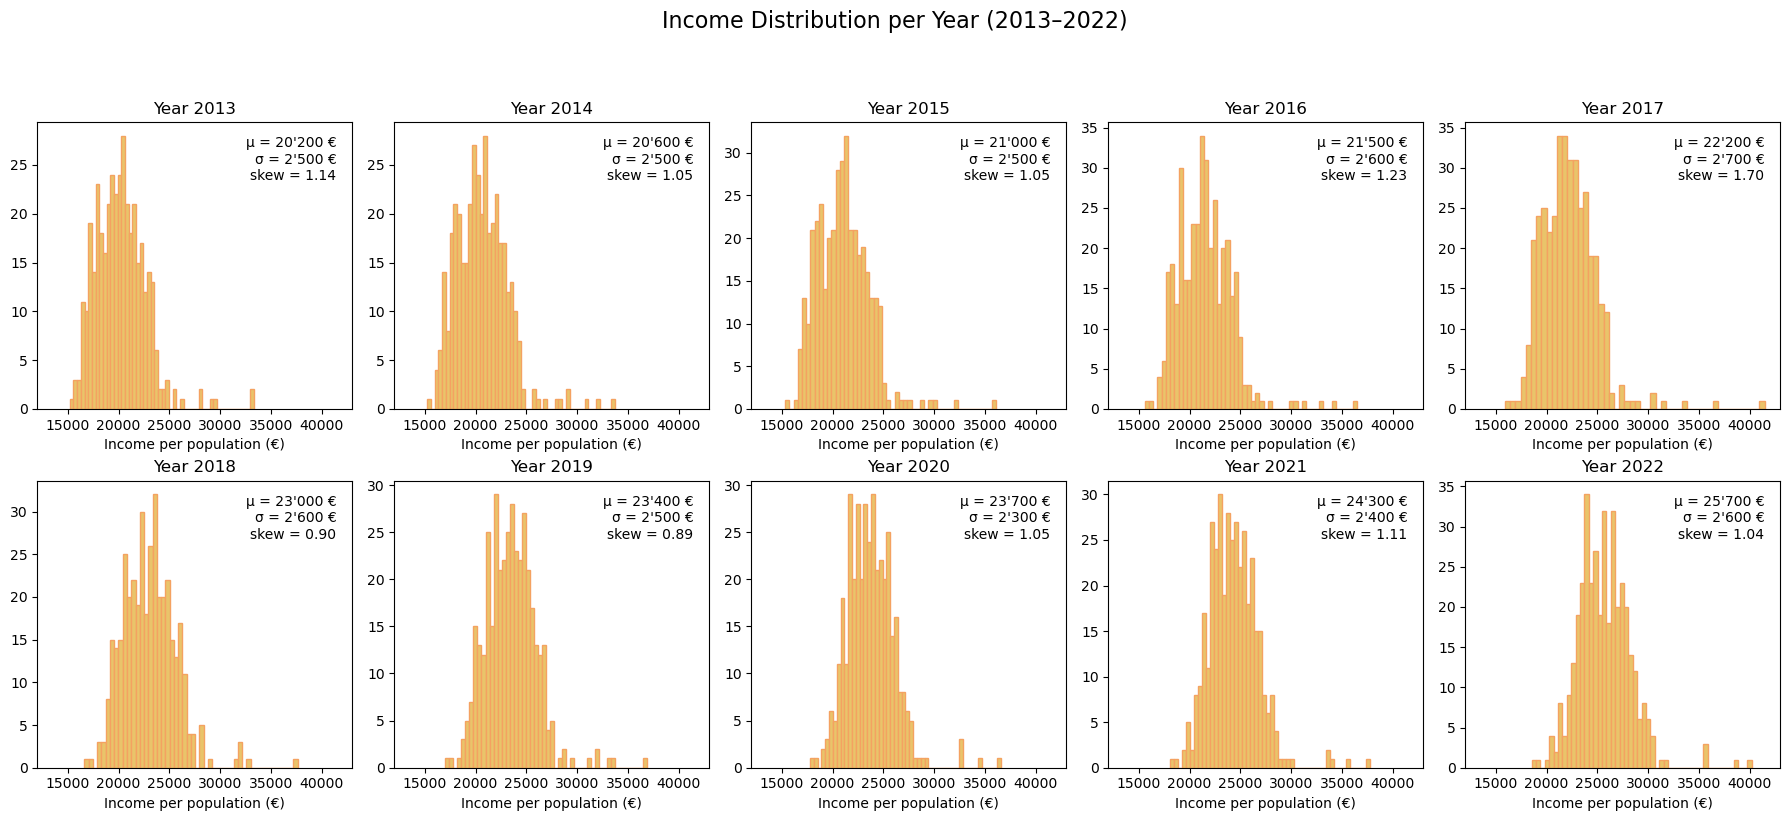

In [7]:
mean_list = []
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.flatten()  

for i, year in enumerate(range(2013, 2023)):
    ax = axes[i]
    
    
    data_sel = df_target[df_target["Jahr"] == year]["Einkommen"]
    
    mean_val = data_sel.mean()
    std_val = data_sel.std()
    skew_val = skew(data_sel)

    mean_list.append(mean_val)

    ax.hist(data_sel, bins=50, edgecolor=colors[3], color=colors[2])
    
    ax.set_title(f"Year {year}", fontsize=12)
    ax.text(0.95, 0.95, 
            f"μ = {int(round(mean_val, -2)):,} €\nσ = {int(round(std_val, -2)):,} €\nskew = {skew_val:.2f}".replace(",", "'"), 
            ha='right', va='top', transform=ax.transAxes,
            fontsize=10, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
    ax.set_xlim(12000,43000)
    ax.set_xlabel("Income per population (€)")


plt.tight_layout()
plt.suptitle("Income Distribution per Year (2013–2022)", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.88)
plt.show()


### Adjust the distrbution towards entire dataset mean

In [9]:
mean_tot = np.array(mean_list).mean()

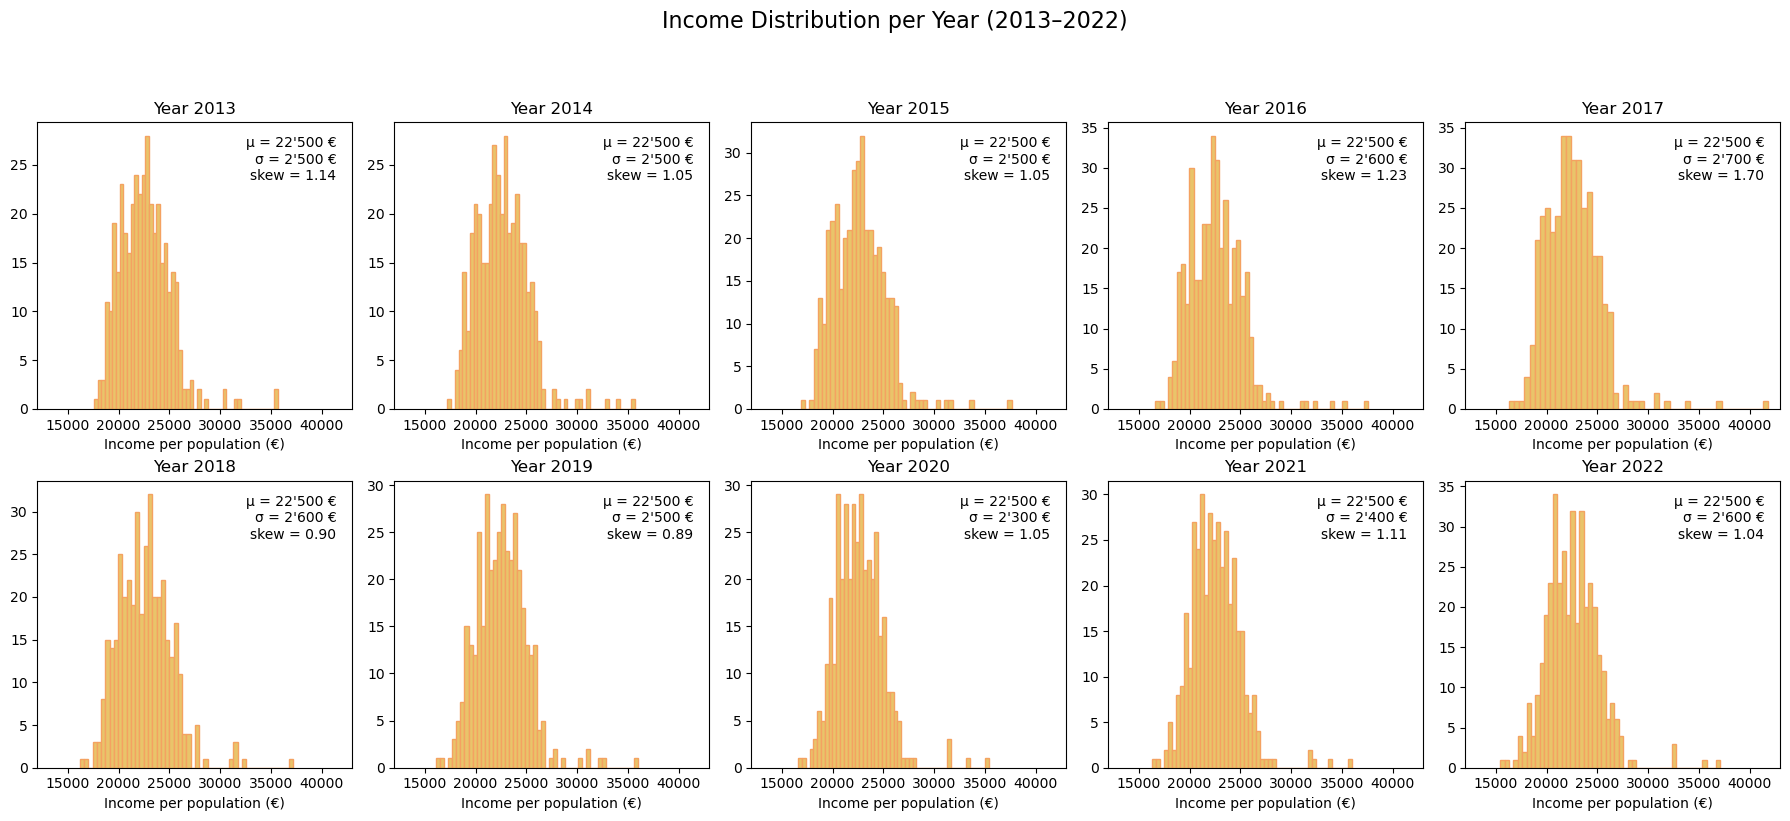

In [10]:
data_sel_list = []

fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.flatten()  

for i, year in enumerate(range(2013, 2023)):
    ax = axes[i]
    
    data_sel = df_norm[df_norm["Jahr"] == year]["Einkommen"] 
    
    mean_val = data_sel.mean()
    std_val = data_sel.std()
    skew_val = skew(data_sel)

    

    mean_diff = mean_tot-mean_val
    data_sel = data_sel + mean_diff

    mean_val = data_sel.mean()
    std_val = data_sel.std()
    skew_val = skew(data_sel)

    data_sel_list.append(data_sel)
    
    ax.hist(data_sel, bins=50, edgecolor=colors[3], color=colors[2])
    
    ax.set_title(f"Year {year}", fontsize=12)
    ax.text(0.95, 0.95, 
            f"μ = {int(round(mean_val, -2)):,} €\nσ = {int(round(std_val, -2)):,} €\nskew = {skew_val:.2f}".replace(",", "'"), 
            ha='right', va='top', transform=ax.transAxes,
            fontsize=10, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
    ax.set_xlim(12000,43000)
    ax.set_xlabel("Income per population (€)")

plt.tight_layout()
plt.suptitle("Income Distribution per Year (2013–2022)", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.88)
plt.show()

### Define income classes

In [17]:
df_target["Einkommen (adjusted)"] = np.concatenate(data_sel_list)
data_sel = df_target["Einkommen (adjusted)"]
high_cutoff = data_sel.quantile(0.95)
middle_cutoff = data_sel.quantile(0.5)
low_cutoff = data_sel.quantile(0.05)

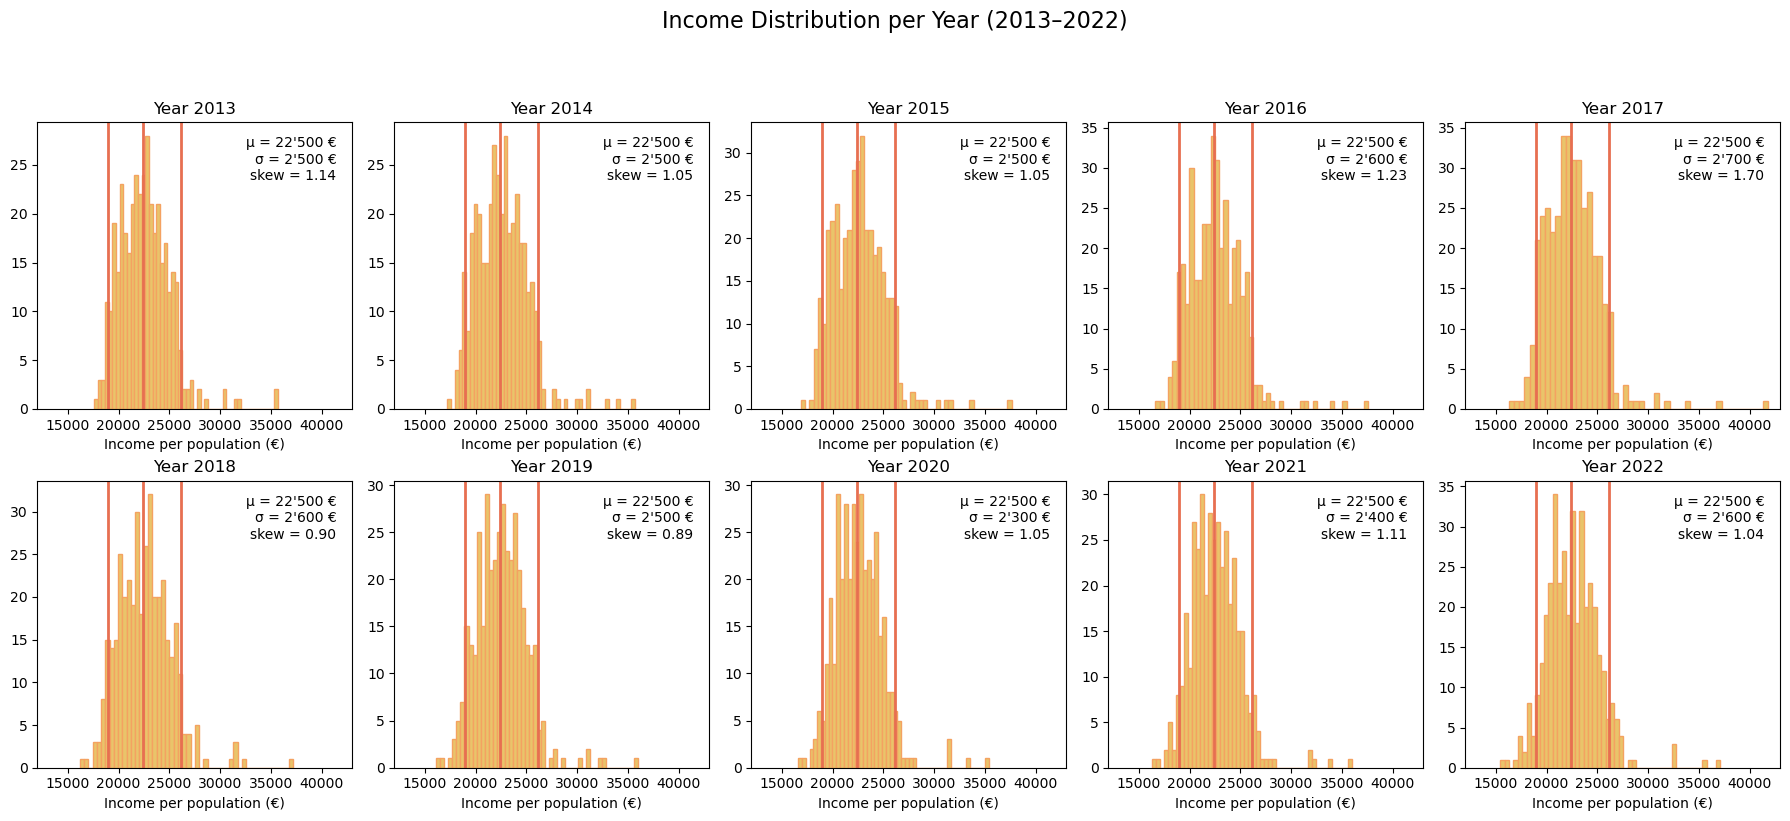

In [18]:
income_cat_list = []

fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.flatten()  

for i, year in enumerate(range(2013, 2023)):
    ax = axes[i]
    
    data_sel = df_norm[df_norm["Jahr"] == year]["Einkommen"] 
    
    mean_val = data_sel.mean()
    std_val = data_sel.std()
    skew_val = skew(data_sel)

    mean_diff = mean_tot-mean_val
    data_sel = data_sel + mean_diff

    mean_val = data_sel.mean()
    std_val = data_sel.std()
    skew_val = skew(data_sel)

    ax.axvline(x=low_cutoff, color=colors[4], linewidth=2, label='Mean +Std')
    ax.axvline(x=high_cutoff, color=colors[4], linewidth=2, label='Mean +Std')
    ax.axvline(x=middle_cutoff, color=colors[4], linewidth=2, label='Mean +Std')

    cat_data = data_sel.copy()
    cat_data.loc[cat_data < low_cutoff] = 0
    cat_data.loc[(cat_data >= low_cutoff) & (cat_data < middle_cutoff)] = 1
    cat_data.loc[(cat_data >= middle_cutoff) & (cat_data < high_cutoff)] = 2
    cat_data.loc[cat_data > high_cutoff] = 3
    income_cat_list.append(cat_data)
    
    ax.hist(data_sel, bins=50, edgecolor=colors[3], color=colors[2])
    
    ax.set_title(f"Year {year}", fontsize=12)
    ax.text(0.95, 0.95, 
            f"μ = {int(round(mean_val, -2)):,} €\nσ = {int(round(std_val, -2)):,} €\nskew = {skew_val:.2f}".replace(",", "'"), 
            ha='right', va='top', transform=ax.transAxes,
            fontsize=10, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
    ax.set_xlim(12000,43000)
    ax.set_xlabel("Income per population (€)")

plt.tight_layout()
plt.suptitle("Income Distribution per Year (2013–2022)", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.88)
plt.show()

In [19]:
income_category = np.concatenate(income_cat_list)
df_target["Income category"] = income_category

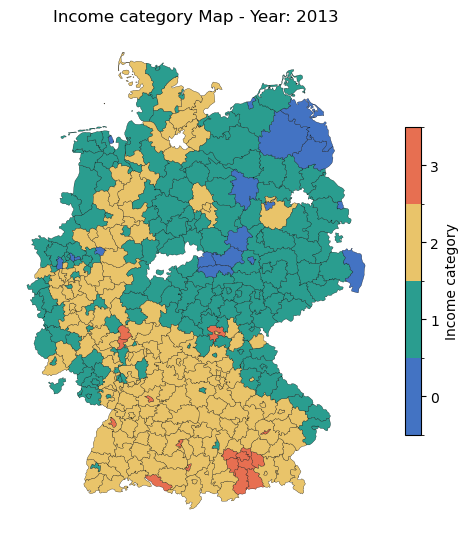

In [28]:
num_clusters = 5

cmap = ListedColormap(colors)
bounds = [0, 1, 2, 3, 4][:num_clusters]
norm = BoundaryNorm(bounds, ncolors=len(colors))


fig, ax = plt.subplots(figsize=(6, 8))

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbar = fig.colorbar(sm, ax=ax, shrink=0.5, ticks=[0.5, 1.5, 2.5, 3.5][:num_clusters])
cbar.ax.set_yticklabels(['0', '1', '2', '3'][:num_clusters])
cbar.set_label("Income category")

def update(year):
    ax.clear()

    df_select = df_target[df_target['Jahr'] == year].copy()
    geo_merged = gdf.merge(df_select, left_on='AGS', right_on='Code')

    geo_merged.plot(
        column='Income category',
        cmap=cmap,
        norm=norm,
        ax=ax,
        edgecolor='black',
        linewidth=0.2
    )

    ax.set_title(f"Income category Map - Year: {year}")
    ax.axis('off')

anim = FuncAnimation(fig, update, frames=range(2013, 2023), interval=800, repeat=True)

anim.save('Income category_animation.gif', writer='pillow', fps=0.5)



# Clustering

In [21]:
df = df_features.drop(columns=['Jahr', 'Code', 'Name']+ Schulen1995_keys).copy()
df["Einkommen (adjusted)"] = df_target["Einkommen (adjusted)"]
df_scaled = StandardScaler().fit_transform(df)

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

for k in range(2,10):
    
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(df_pca)
    score = silhouette_score(df_scaled, clusters)
    print(score)


0.3005663319315808
0.1963658981729572
0.19750902320534724
0.14232239119291373
0.14994241186372012
0.13054649122947803
0.12335086845730545
0.1186114474591099


Index(['Ausländer (m)', 'Ausländer (w)', 'Ausländer', 'Arbeitslose',
       'Arbeitslose (ausl.)', 'Arbeitslose (s.beh.)', 'Arbeitslose (15-20)',
       'Arbeitslose (15-25)', 'Arbeitslose (55-65)', 'langzeitarbeitslos',
       'Beschäftigte (tot.)', 'mit akademischem Abschluss (tot.)',
       'mit anerkanntem Berufsabschluss (tot.)', 'ohne Berufsabschluss (tot.)',
       'Beschäftigte (ausl.)', 'mit akademischem Abschluss (ausl.)',
       'mit anerkanntem Berufsabschluss (ausl.)',
       'ohne Berufsabschluss (ausl.)', 'MSL (tot.)', 'SGB II (tot.)',
       'SGB II (erwerbsf.)', 'SGB II (n.erwerbsf.)', 'SGB XII (Lebensunt.)',
       'SGB XII (Grundsicher.)', 'Regelleist. (Asyl)', 'Erwerbstätige (tot.)',
       'A', 'B-E', 'C', 'F', 'G-J', 'V', 'Ö', 'Einkommen (adjusted)'],
      dtype='object')

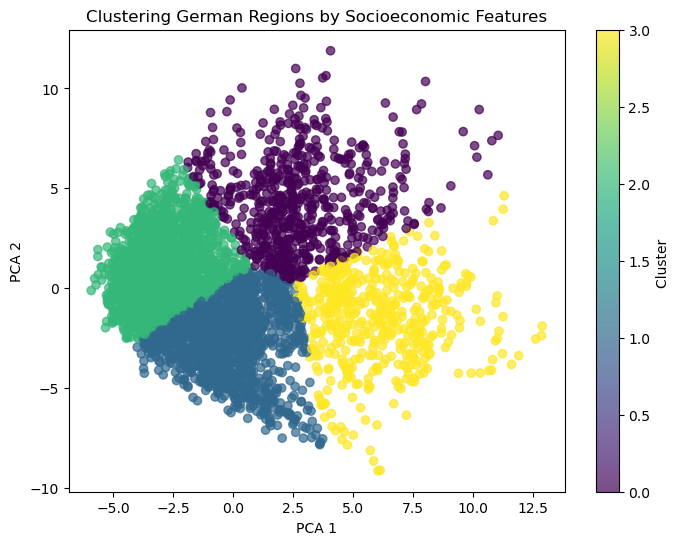

In [25]:
df = df_features.drop(columns=['Jahr', 'Code', 'Name']+ Schulen1995_keys).copy()
df["Einkommen (adjusted)"] = df_target["Einkommen (adjusted)"]
display(df.keys())
df_scaled = StandardScaler().fit_transform(df)

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(df_pca)

plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.title("Clustering German Regions by Socioeconomic Features")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster ")
plt.show()


In [26]:
df_target['cluster'] = clusters

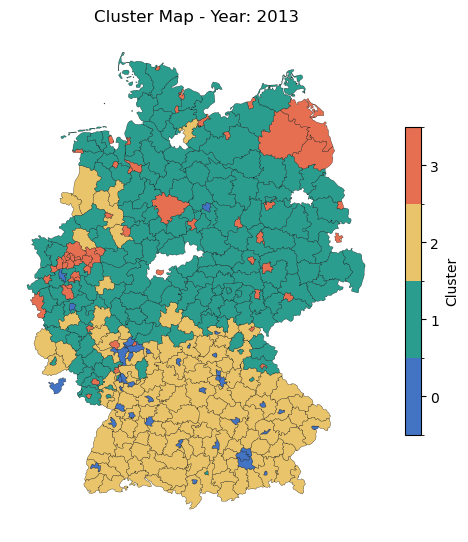

In [27]:

cmap = ListedColormap(colors)
bounds = [0, 1, 2, 3, 4]
norm = BoundaryNorm(bounds, ncolors=len(colors))


fig, ax = plt.subplots(figsize=(6, 8))

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbar = fig.colorbar(sm, ax=ax, shrink=0.5, ticks=[0.5, 1.5, 2.5, 3.5])
cbar.ax.set_yticklabels(['0', '1', '2', '3'])
cbar.set_label("Cluster")

def update(year):
    ax.clear()

    df_select = df_target[df_norm['Jahr'] == year].copy()
    geo_merged = gdf.merge(df_select, left_on='AGS', right_on='Code')

    geo_merged.plot(
        column='cluster',
        cmap=cmap,
        norm=norm,
        ax=ax,
        edgecolor='black',
        linewidth=0.2
    )

    ax.set_title(f"Cluster Map - Year: {year}")
    ax.axis('off')

anim = FuncAnimation(fig, update, frames=range(2013, 2023), interval=800, repeat=True)

anim.save('cluster_animation.gif', writer='pillow', fps=1)



## Save for NN

In [44]:
# df_norm["Einkommen"] = dataset["Einkommen"]
# features = df_norm.drop(columns=["Jahr","Code","Name",
# "Einkommen",
# "Arbeitslose",
# "Arbeitslose (ausl.)",
# "Arbeitslose (s.beh.)",
# "Arbeitslose (15-20)",
# "Arbeitslose (15-25)",
# "Arbeitslose (55-65)", "Einkommen (adjusted)"]).keys()

# targets = df_norm[["Einkommen",
# "Arbeitslose",
# "Arbeitslose (ausl.)",
# "Arbeitslose (s.beh.)",
# "Arbeitslose (15-20)",
# "Arbeitslose (15-25)",
# "Arbeitslose (55-65)"]].keys()
# targets = ["Einkommen (adjusted)"]

# scaler_x = StandardScaler()
# scaler_y = MinMaxScaler()


# df_scaled = df_norm.copy()

# df_scaled[features] = scaler_x.fit_transform(df_scaled[features])
# df_scaled[targets] = scaler_y.fit_transform(df_scaled[targets])

# display(df_scaled[features].shape)
# display(df_scaled[targets].shape)

# window_size = 3
# windows = {}
# target_values = {}

# for id, group in df_scaled.groupby("Code"):
#     id_str = str(id)
#     features_x_df = group[features].to_numpy()
#     features_y_df = group[targets].to_numpy()[window_size-1:]

#     window = sliding_window_view(features_x_df, (window_size, features_x_df.shape[1]))[:, 0, :]

#     windows[id_str] = window
#     target_values[id_str] = features_y_df

# np.savez("Data/data_x.npz", **windows)
# np.savez("Data/data_y.npz", **target_values)

## Feature correlation

Index(['Ausländer (m)', 'Ausländer (w)', 'Ausländer', 'Arbeitslose',
       'Arbeitslose (ausl.)', 'Arbeitslose (s.beh.)', 'Arbeitslose (15-20)',
       'Arbeitslose (15-25)', 'Arbeitslose (55-65)', 'langzeitarbeitslos',
       'Abendschulen und Kollegs (1995)', 'Freie Waldorfschulen (1995)',
       'Grundschulen (1995)', 'Gymnasien (1995)', 'Hauptschulen (1995)',
       'Integrierte Gesamtschulen (1995)', 'Realschulen (1995)',
       'Schularten mit mehreren Bildungsgängen (1995)',
       'Schulartunabhängige Orientierungsstufe (1995)',
       'Sonderschulen/ Förderschulen (1995)', 'Vorschulbereich (1995)',
       'Beschäftigte (tot.)', 'mit akademischem Abschluss (tot.)',
       'mit anerkanntem Berufsabschluss (tot.)', 'ohne Berufsabschluss (tot.)',
       'Beschäftigte (ausl.)', 'mit akademischem Abschluss (ausl.)',
       'mit anerkanntem Berufsabschluss (ausl.)',
       'ohne Berufsabschluss (ausl.)', 'MSL (tot.)', 'SGB II (tot.)',
       'SGB II (erwerbsf.)', 'SGB II (n.erwerbsf

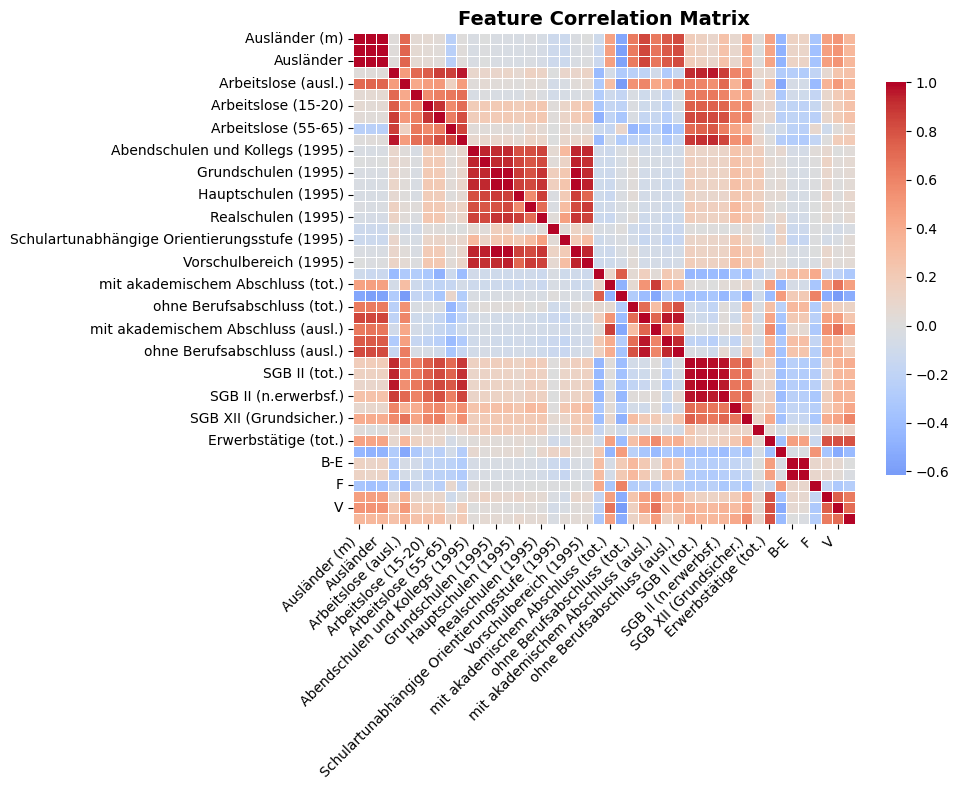

In [33]:
# including unemployed rates

corr = df_features.drop(columns=identifiers).corr()
display(corr.keys())

plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', center=0, linewidths=0.5,
            cbar_kws={"shrink": 0.8})
plt.title("Feature Correlation Matrix", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Index(['Ausländer (m)', 'Ausländer (w)', 'Ausländer',
       'Abendschulen und Kollegs (1995)', 'Freie Waldorfschulen (1995)',
       'Grundschulen (1995)', 'Gymnasien (1995)', 'Hauptschulen (1995)',
       'Integrierte Gesamtschulen (1995)', 'Realschulen (1995)',
       'Schularten mit mehreren Bildungsgängen (1995)',
       'Schulartunabhängige Orientierungsstufe (1995)',
       'Sonderschulen/ Förderschulen (1995)', 'Vorschulbereich (1995)',
       'Beschäftigte (tot.)', 'mit akademischem Abschluss (tot.)',
       'mit anerkanntem Berufsabschluss (tot.)', 'ohne Berufsabschluss (tot.)',
       'Beschäftigte (ausl.)', 'mit akademischem Abschluss (ausl.)',
       'mit anerkanntem Berufsabschluss (ausl.)',
       'ohne Berufsabschluss (ausl.)', 'MSL (tot.)', 'SGB II (tot.)',
       'SGB II (erwerbsf.)', 'SGB II (n.erwerbsf.)', 'SGB XII (Lebensunt.)',
       'SGB XII (Grundsicher.)', 'Regelleist. (Asyl)', 'Erwerbstätige (tot.)',
       'A', 'B-E', 'C', 'F', 'G-J', 'V', 'Ö'],
      dtype=

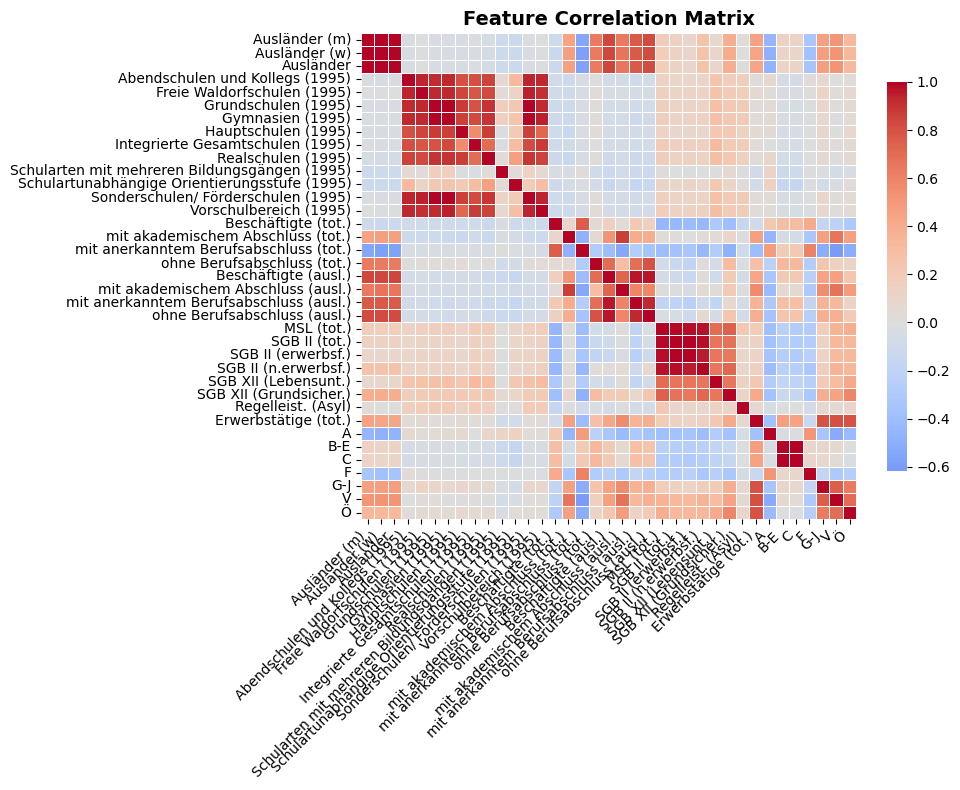

In [34]:
# excluding unemployed rates

corr = df_features.drop(columns=identifiers+Arbeitslose_keys).corr()
display(corr.keys())

plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', center=0, linewidths=0.5,
            cbar_kws={"shrink": 0.8})
plt.title("Feature Correlation Matrix", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [46]:
non_correlated_features = ["Ausländer", "Abendschulen und Kollegs (1995)", 'mit akademischem Abschluss (tot.)',"SGB II (erwerbsf.)", "Ö"]
## Correlation between these are all below 0.5, higher correlation is present only with income, see next plot

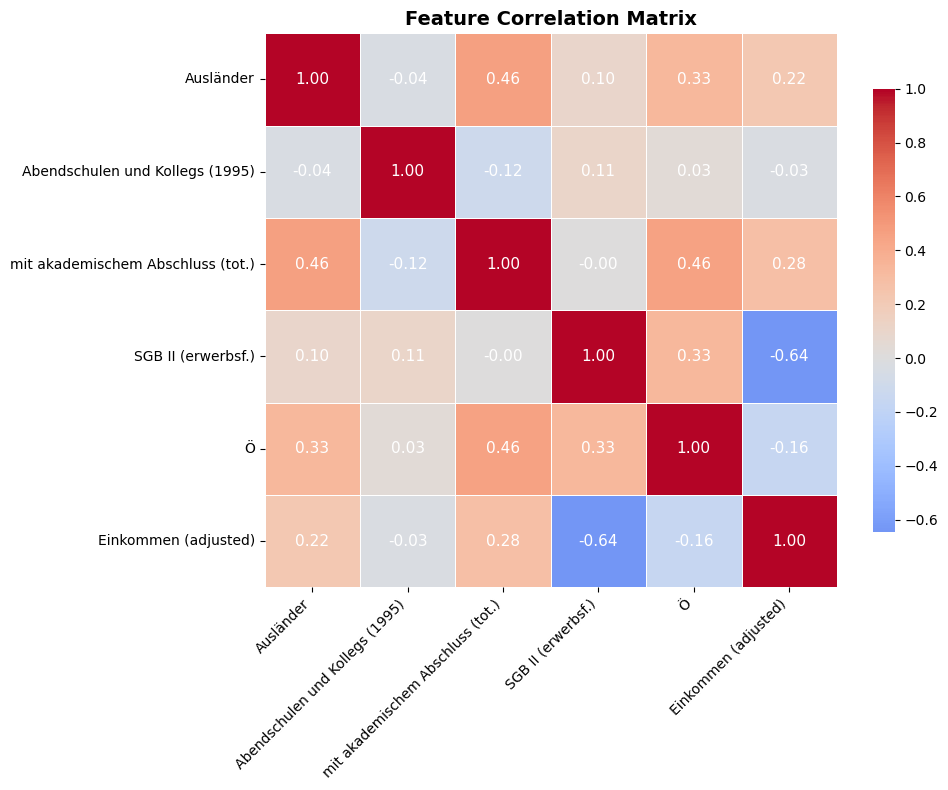

In [45]:
df_tot = df_features[non_correlated_features].copy()
df_tot["Einkommen (adjusted)"] = df_target["Einkommen (adjusted)"]

corr = df_tot.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', center=0, linewidths=0.5,
            cbar_kws={"shrink": 0.8})
plt.title("Feature Correlation Matrix", fontsize=14, fontweight='bold')
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        corr_val = np.array(corr)[i,j]
        text = f"{corr_val:.2f}"
        plt.text(j + 0.5, i + 0.5, text,
                ha='center', va='center',
                color='black' if np.abs(corr_val) < 0 else 'white',
                fontsize=11)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification and Regression with all the features
## Random Forest

In [30]:
X = df_features.drop(columns=identifiers)

y = df_target['Income category']

X_scaled = StandardScaler().fit_transform(X)

n_runs = 30
feature_ranks = pd.DataFrame(index=X.columns)
acc_list = []
train_acc_list = []
f1_macro_list = []
conf_matrices = []

for seed in range(n_runs):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=seed
    )

    X_train = StandardScaler().fit_transform(X_train)
    X_test = StandardScaler().fit_transform(X_test)

    class_weights = {0: 4, 1: 1.0, 2: 1.0, 3: 9} 

    clf = RandomForestClassifier(n_estimators=120, random_state=seed,min_samples_leaf=40, max_depth=8, max_features="log2",class_weight=class_weights)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_train_pred = clf.predict(X_train)


    acc_list.append(accuracy_score(y_test, y_pred))
    train_acc_list.append(accuracy_score(y_train, y_train_pred))
    f1_macro_list.append(f1_score(y_test, y_pred, average='macro'))
    conf_matrices.append(confusion_matrix(y_test, y_pred))

    result = permutation_importance(clf, X_scaled, y, n_repeats=10, random_state=seed)
    importances = pd.Series(result.importances_mean, index=X.columns)
    ranks = importances.rank(ascending=False, method='min')
    feature_ranks[f'run_{seed}'] = ranks

feature_ranks['avg_rank'] = feature_ranks.mean(axis=1)
feature_ranks['std_rank'] = feature_ranks.std(axis=1)
rank_summary = feature_ranks.sort_values('avg_rank')

avg_conf_mat = np.mean(conf_matrices, axis=0)



=== Performance over 30 runs ===
Mean Accuracy:     0.713 ± 0.016
Mean Train Accuracy:     0.769 ± 0.006
Mean Macro F1:     0.636 ± 0.021

=== Average Confusion Matrix ===
[[ 28  10   0   0]
 [ 38 250  57   6]
 [  1  62 248  39]
 [  0   1  10  30]]

=== STD of Confusion Matrix ===
[[ 4  3  0  0]
 [ 5  9  9  2]
 [ 1  9 10  8]
 [ 0  1  4  4]]

=== Top Features by Average Rank ===
                                                avg_rank  std_rank
ohne Berufsabschluss (tot.)                     3.166667  3.578485
Sonderschulen/ Förderschulen (1995)             5.466667  3.947432
C                                               6.933333  5.597222
F                                               7.066667  4.767482
Realschulen (1995)                              8.500000  4.814907
mit anerkanntem Berufsabschluss (tot.)          8.866667  5.554178
B-E                                             8.900000  5.769749
Gymnasien (1995)                                9.966667  5.332187
Hauptschulen (19

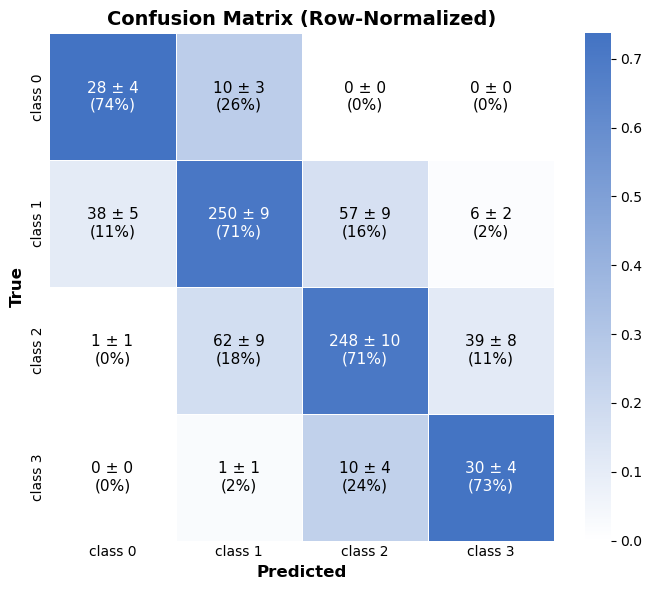

In [31]:
print("=== Performance over 30 runs ===")
print(f"Mean Accuracy:     {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}")
print(f"Mean Train Accuracy:     {np.mean(train_acc_list):.3f} ± {np.std(train_acc_list):.3f}")
print(f"Mean Macro F1:     {np.mean(f1_macro_list):.3f} ± {np.std(f1_macro_list):.3f}")

print("\n=== Average Confusion Matrix ===")
print(np.round(avg_conf_mat).astype(int))

std_conf_mat = np.std(conf_matrices, axis=0)
print("\n=== STD of Confusion Matrix ===")
print(np.round(std_conf_mat).astype(int))

print("\n=== Top Features by Average Rank ===")
print(rank_summary[['avg_rank', 'std_rank']])

class_names = ['Low', 'Medium low','Medium high', 'High']
class_names = ['Category 0', 'Category 1', 'Category 2', 'Category 3']
class_names = ["class "+str(i) for i in range(4)]

conf_matr = np.round(avg_conf_mat).astype(int)
conf_matr_std = np.round(std_conf_mat).astype(int)

blue_shade = "#4373c3"
custom_cmap = LinearSegmentedColormap.from_list("custom_blue", ["white", blue_shade])

row_sums = conf_matr.sum(axis=1, keepdims=True)
norm_conf = conf_matr / row_sums

plt.figure(figsize=(7, 6))
ax = sns.heatmap(norm_conf, annot=False, fmt='.2f', cmap=custom_cmap,
                 xticklabels=class_names, yticklabels=class_names,
                 cbar=True, linewidths=0.5)
ax.tick_params(axis='both', length=0)

for i in range(conf_matr.shape[0]):
    for j in range(conf_matr.shape[1]):
        count = conf_matr[i, j]
        std = conf_matr_std[i,j]
        perc = norm_conf[i, j] * 100
        text = f"{count} ± {std}\n({perc:.0f}%)"
        ax.text(j + 0.5, i + 0.5, text,
                ha='center', va='center',
                color='black' if perc < 60 else 'white',
                fontsize=11)

plt.xlabel('Predicted', fontsize=12, fontweight = "bold")
plt.ylabel('True', fontsize=12, fontweight = "bold")
plt.title('Confusion Matrix (Row-Normalized)', fontsize=14, fontweight = "bold")
plt.tight_layout()
plt.show()


## Multiple Linear Regression

(remove a few features that are too correlated (list: `drop_double`) because the Model is unstable)

In [35]:
drop_double = ["Ausländer", "Erwerbstätige (tot.)", "Beschäftigte (tot.)"]

X = df_features.drop(columns=identifiers + drop_double)
y = df_target['Einkommen (adjusted)']

X_scaled = StandardScaler().fit_transform(X)

r2_list = []
r2_train_list = []
rmse_list = []
coeff_list = []

for seed in range(n_runs):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=seed
    )
    X_train = StandardScaler().fit_transform(X_train)
    X_test = StandardScaler().fit_transform(X_test)

    model = LinearRegression()

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    r2 = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_train_pred)

    rmse = root_mean_squared_error(y_test, y_pred)
    r2_list.append(r2)
    r2_train_list.append(r2_train)
    rmse_list.append(rmse)

    coeffs = model.coef_ #pd.Series(model.coef_, index=X.columns)
    coeff_list.append(model.coef_)

print("R² Score:", round(np.mean(np.array(r2_list)), 3), " +- ", round(np.std(np.array(r2_list)), 3))
print("R² Score (train):", round(np.mean(np.array(r2_train_list)), 3), " +- ", round(np.std(np.array(r2_train_list)), 3))

print("RMSE:", round(np.mean(np.array(rmse_list)), 2), " +- ", round(np.std(np.array(rmse_list)), 2))

print("\nIntercept:", round(model.intercept_, 2))
print("\nCoefficients:")
coeffs_mean = np.mean(np.array(coeff_list), axis=0)
coeffs_mean = pd.Series(coeffs_mean, index=X.columns)
coeffs_mean = coeffs_mean.sort_values(ascending=False)


coeffs_std = np.std(np.array(coeff_list), axis=0)
coeffs_std = pd.Series(coeffs_std, index=X.columns)
coeffs_std = coeffs_std.sort_values(ascending=False)

with pd.option_context('display.max_rows', None):
    print(coeffs_mean)


result = permutation_importance(model, X_scaled, y, scoring='r2', n_repeats=10, random_state=0)
perm_importance = pd.Series(result.importances_mean, index=X.columns)
print(perm_importance.sort_values(ascending=False))


R² Score: 0.691  +-  0.023
R² Score (train): 0.704  +-  0.005
RMSE: 1420.05  +-  83.08

Intercept: 22533.0

Coefficients:
Ausländer (w)                                    3074.292037
C                                                2354.705925
Beschäftigte (ausl.)                             2009.668861
Gymnasien (1995)                                 1299.921975
mit anerkanntem Berufsabschluss (ausl.)           756.058197
langzeitarbeitslos                                719.039227
MSL (tot.)                                        673.268803
V                                                 508.384198
mit akademischem Abschluss (tot.)                 495.119431
Abendschulen und Kollegs (1995)                   468.507088
Arbeitslose (15-25)                               464.794351
ohne Berufsabschluss (tot.)                       329.212720
G-J                                               294.884256
Grundschulen (1995)                               256.970711
Arbeitslose (55-65)     

# Classification and Regression with all the features but excluding unimployed rates
## Random Forest

In [36]:
X = df_features.drop(columns=identifiers + Arbeitslose_keys)

y = df_target['Income category']

X_scaled = StandardScaler().fit_transform(X)

n_runs = 30
feature_ranks = pd.DataFrame(index=X.columns)
acc_list = []
train_acc_list = []
f1_macro_list = []
conf_matrices = []

for seed in range(n_runs):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=seed
    )

    X_train = StandardScaler().fit_transform(X_train)
    X_test = StandardScaler().fit_transform(X_test)

    class_weights = {0: 4, 1: 1.0, 2: 1.0, 3: 9} 

    clf = RandomForestClassifier(n_estimators=120, random_state=seed,min_samples_leaf=40, max_depth=8, max_features="log2",class_weight=class_weights)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_train_pred = clf.predict(X_train)


    acc_list.append(accuracy_score(y_test, y_pred))
    train_acc_list.append(accuracy_score(y_train, y_train_pred))
    f1_macro_list.append(f1_score(y_test, y_pred, average='macro'))
    conf_matrices.append(confusion_matrix(y_test, y_pred))

    result = permutation_importance(clf, X_scaled, y, n_repeats=10, random_state=seed)
    importances = pd.Series(result.importances_mean, index=X.columns)
    ranks = importances.rank(ascending=False, method='min')
    feature_ranks[f'run_{seed}'] = ranks

feature_ranks['avg_rank'] = feature_ranks.mean(axis=1)
feature_ranks['std_rank'] = feature_ranks.std(axis=1)
rank_summary = feature_ranks.sort_values('avg_rank')

avg_conf_mat = np.mean(conf_matrices, axis=0)



=== Performance over 30 runs ===
Mean Accuracy:     0.723 ± 0.019
Mean Train Accuracy:     0.780 ± 0.008
Mean Macro F1:     0.644 ± 0.026

=== Average Confusion Matrix ===
[[ 29   9   0   0]
 [ 36 258  51   6]
 [  2  62 246  39]
 [  0   1  10  30]]

=== STD of Confusion Matrix ===
[[ 3  4  0  0]
 [ 7 11  7  3]
 [ 1 10 11 10]
 [ 0  1  5  5]]

=== Top Features by Average Rank ===
                                                avg_rank  std_rank
Sonderschulen/ Förderschulen (1995)             2.966667  1.494062
ohne Berufsabschluss (tot.)                     3.533333  3.343983
Gymnasien (1995)                                4.433333  2.836469
G-J                                             5.533333  4.088466
V                                               6.866667  4.544105
mit anerkanntem Berufsabschluss (tot.)          7.966667  5.540658
Ö                                               9.900000  5.022284
mit akademischem Abschluss (tot.)              10.566667  5.748526
Freie Waldorfsch

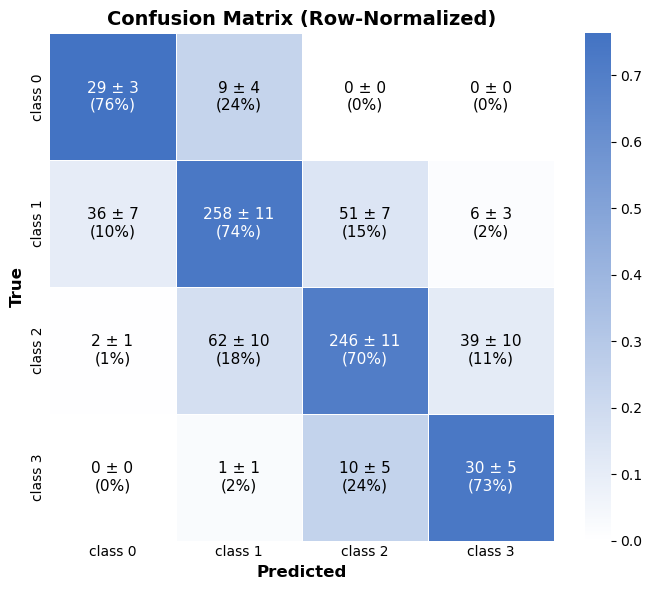

In [37]:
print("=== Performance over 30 runs ===")
print(f"Mean Accuracy:     {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}")
print(f"Mean Train Accuracy:     {np.mean(train_acc_list):.3f} ± {np.std(train_acc_list):.3f}")
print(f"Mean Macro F1:     {np.mean(f1_macro_list):.3f} ± {np.std(f1_macro_list):.3f}")

print("\n=== Average Confusion Matrix ===")
print(np.round(avg_conf_mat).astype(int))

std_conf_mat = np.std(conf_matrices, axis=0)
print("\n=== STD of Confusion Matrix ===")
print(np.round(std_conf_mat).astype(int))

print("\n=== Top Features by Average Rank ===")
print(rank_summary[['avg_rank', 'std_rank']])

class_names = ['Low', 'Medium low','Medium high', 'High']
class_names = ['Category 0', 'Category 1', 'Category 2', 'Category 3']
class_names = ["class "+str(i) for i in range(4)]

conf_matr = np.round(avg_conf_mat).astype(int)
conf_matr_std = np.round(std_conf_mat).astype(int)

blue_shade = "#4373c3"
custom_cmap = LinearSegmentedColormap.from_list("custom_blue", ["white", blue_shade])

row_sums = conf_matr.sum(axis=1, keepdims=True)
norm_conf = conf_matr / row_sums

plt.figure(figsize=(7, 6))
ax = sns.heatmap(norm_conf, annot=False, fmt='.2f', cmap=custom_cmap,
                 xticklabels=class_names, yticklabels=class_names,
                 cbar=True, linewidths=0.5)
ax.tick_params(axis='both', length=0)

for i in range(conf_matr.shape[0]):
    for j in range(conf_matr.shape[1]):
        count = conf_matr[i, j]
        std = conf_matr_std[i,j]
        perc = norm_conf[i, j] * 100
        text = f"{count} ± {std}\n({perc:.0f}%)"
        ax.text(j + 0.5, i + 0.5, text,
                ha='center', va='center',
                color='black' if perc < 60 else 'white',
                fontsize=11)

plt.xlabel('Predicted', fontsize=12, fontweight = "bold")
plt.ylabel('True', fontsize=12, fontweight = "bold")
plt.title('Confusion Matrix (Row-Normalized)', fontsize=14, fontweight = "bold")
plt.tight_layout()
plt.show()


## Multiple Linear Regression

In [38]:
drop_double = ["Ausländer", "Erwerbstätige (tot.)", "Beschäftigte (tot.)"]

X = df_features.drop(columns=identifiers + drop_double + Arbeitslose_keys)
y = df_target['Einkommen (adjusted)']

X_scaled = StandardScaler().fit_transform(X)

r2_list = []
r2_train_list = []
rmse_list = []
coeff_list = []

for seed in range(n_runs):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=seed
    )
    X_train = StandardScaler().fit_transform(X_train)
    X_test = StandardScaler().fit_transform(X_test)

    model = LinearRegression()

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    r2 = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_train_pred)

    rmse = root_mean_squared_error(y_test, y_pred)
    r2_list.append(r2)
    r2_train_list.append(r2_train)
    rmse_list.append(rmse)

    coeffs = model.coef_ #pd.Series(model.coef_, index=X.columns)
    coeff_list.append(model.coef_)

print("R² Score:", round(np.mean(np.array(r2_list)), 3), " +- ", round(np.std(np.array(r2_list)), 3))
print("R² Score (train):", round(np.mean(np.array(r2_train_list)), 3), " +- ", round(np.std(np.array(r2_train_list)), 3))

print("RMSE:", round(np.mean(np.array(rmse_list)), 2), " +- ", round(np.std(np.array(rmse_list)), 2))

print("\nIntercept:", round(model.intercept_, 2))
print("\nCoefficients:")
coeffs_mean = np.mean(np.array(coeff_list), axis=0)
coeffs_mean = pd.Series(coeffs_mean, index=X.columns)
coeffs_mean = coeffs_mean.sort_values(ascending=False)


coeffs_std = np.std(np.array(coeff_list), axis=0)
coeffs_std = pd.Series(coeffs_std, index=X.columns)
coeffs_std = coeffs_std.sort_values(ascending=False)

with pd.option_context('display.max_rows', None):
    print(coeffs_mean)


result = permutation_importance(model, X_scaled, y, scoring='r2', n_repeats=10, random_state=0)
perm_importance = pd.Series(result.importances_mean, index=X.columns)
print(perm_importance.sort_values(ascending=False))


R² Score: 0.678  +-  0.022
R² Score (train): 0.689  +-  0.005
RMSE: 1449.63  +-  81.48

Intercept: 22533.0

Coefficients:
Ausländer (w)                                    3034.151194
C                                                2699.700417
Beschäftigte (ausl.)                             1706.314275
Gymnasien (1995)                                 1179.827566
mit anerkanntem Berufsabschluss (ausl.)           911.002137
MSL (tot.)                                        766.219369
mit akademischem Abschluss (tot.)                 629.338660
Abendschulen und Kollegs (1995)                   467.414319
V                                                 458.980001
ohne Berufsabschluss (tot.)                       319.072725
G-J                                               297.787171
Freie Waldorfschulen (1995)                        81.761249
Hauptschulen (1995)                                80.865796
SGB XII (Lebensunt.)                               60.337176
Realschulen (1995)      

# Classification and Regression with subset of low correlated features
## Random Forest

In [40]:
X = df_features[non_correlated_features]

y = df_target['Income category']

X_scaled = StandardScaler().fit_transform(X)

n_runs = 30
feature_ranks = pd.DataFrame(index=X.columns)
acc_list = []
train_acc_list = []
f1_macro_list = []
conf_matrices = []

for seed in range(n_runs):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=seed
    )

    X_train = StandardScaler().fit_transform(X_train)
    X_test = StandardScaler().fit_transform(X_test)

    class_weights = {0: 4, 1: 1.0, 2: 1.0, 3: 9} 

    clf = RandomForestClassifier(n_estimators=120, random_state=seed,min_samples_leaf=40, max_depth=8, max_features="log2",class_weight=class_weights)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_train_pred = clf.predict(X_train)


    acc_list.append(accuracy_score(y_test, y_pred))
    train_acc_list.append(accuracy_score(y_train, y_train_pred))
    f1_macro_list.append(f1_score(y_test, y_pred, average='macro'))
    conf_matrices.append(confusion_matrix(y_test, y_pred))

    result = permutation_importance(clf, X_scaled, y, n_repeats=10, random_state=seed)
    importances = pd.Series(result.importances_mean, index=X.columns)
    ranks = importances.rank(ascending=False, method='min')
    feature_ranks[f'run_{seed}'] = ranks

feature_ranks['avg_rank'] = feature_ranks.mean(axis=1)
feature_ranks['std_rank'] = feature_ranks.std(axis=1)
rank_summary = feature_ranks.sort_values('avg_rank')

avg_conf_mat = np.mean(conf_matrices, axis=0)



=== Performance over 30 runs ===
Mean Accuracy:     0.698 ± 0.015
Mean Train Accuracy:     0.738 ± 0.006
Mean Macro F1:     0.613 ± 0.019

=== Average Confusion Matrix ===
[[ 28  10   0   0]
 [ 38 258  47   9]
 [  1  67 228  54]
 [  0   3   9  30]]

=== STD of Confusion Matrix ===
[[ 3  4  0  0]
 [ 5  7  8  3]
 [ 1  9 10  7]
 [ 0  2  4  4]]

=== Top Features by Average Rank ===
                                   avg_rank  std_rank
SGB II (erwerbsf.)                      1.0  0.000000
Ausländer                               2.0  0.000000
mit akademischem Abschluss (tot.)       3.3  0.458258
Ö                                       3.7  0.458258
Abendschulen und Kollegs (1995)         5.0  0.000000


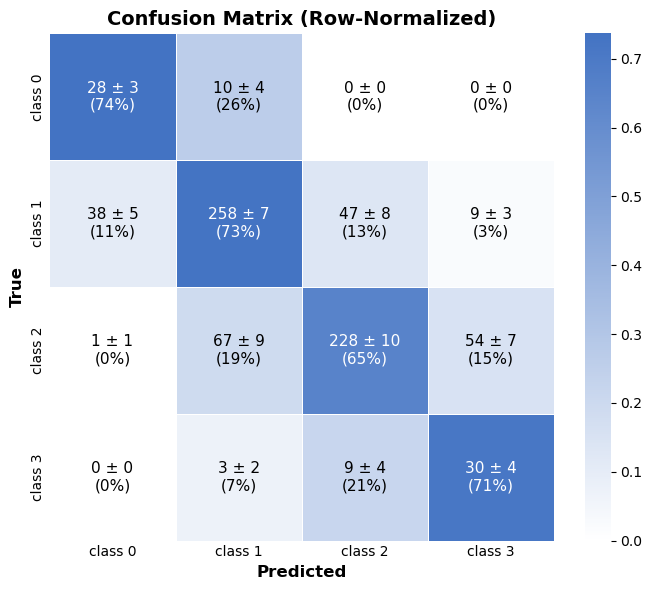

In [41]:
print("=== Performance over 30 runs ===")
print(f"Mean Accuracy:     {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}")
print(f"Mean Train Accuracy:     {np.mean(train_acc_list):.3f} ± {np.std(train_acc_list):.3f}")
print(f"Mean Macro F1:     {np.mean(f1_macro_list):.3f} ± {np.std(f1_macro_list):.3f}")

print("\n=== Average Confusion Matrix ===")
print(np.round(avg_conf_mat).astype(int))

std_conf_mat = np.std(conf_matrices, axis=0)
print("\n=== STD of Confusion Matrix ===")
print(np.round(std_conf_mat).astype(int))

print("\n=== Top Features by Average Rank ===")
print(rank_summary[['avg_rank', 'std_rank']])

class_names = ['Low', 'Medium low','Medium high', 'High']
class_names = ['Category 0', 'Category 1', 'Category 2', 'Category 3']
class_names = ["class "+str(i) for i in range(4)]

conf_matr = np.round(avg_conf_mat).astype(int)
conf_matr_std = np.round(std_conf_mat).astype(int)

blue_shade = "#4373c3"
custom_cmap = LinearSegmentedColormap.from_list("custom_blue", ["white", blue_shade])

row_sums = conf_matr.sum(axis=1, keepdims=True)
norm_conf = conf_matr / row_sums

plt.figure(figsize=(7, 6))
ax = sns.heatmap(norm_conf, annot=False, fmt='.2f', cmap=custom_cmap,
                 xticklabels=class_names, yticklabels=class_names,
                 cbar=True, linewidths=0.5)
ax.tick_params(axis='both', length=0)

for i in range(conf_matr.shape[0]):
    for j in range(conf_matr.shape[1]):
        count = conf_matr[i, j]
        std = conf_matr_std[i,j]
        perc = norm_conf[i, j] * 100
        text = f"{count} ± {std}\n({perc:.0f}%)"
        ax.text(j + 0.5, i + 0.5, text,
                ha='center', va='center',
                color='black' if perc < 60 else 'white',
                fontsize=11)

plt.xlabel('Predicted', fontsize=12, fontweight = "bold")
plt.ylabel('True', fontsize=12, fontweight = "bold")
plt.title('Confusion Matrix (Row-Normalized)', fontsize=14, fontweight = "bold")
plt.tight_layout()
plt.show()


## MLR

In [42]:
X = df_features[non_correlated_features]
y = df_target['Einkommen (adjusted)']

X_scaled = StandardScaler().fit_transform(X)

r2_list = []
r2_train_list = []
rmse_list = []
coeff_list = []

for seed in range(n_runs):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=seed
    )
    X_train = StandardScaler().fit_transform(X_train)
    X_test = StandardScaler().fit_transform(X_test)

    model = LinearRegression()

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    r2 = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_train_pred)

    rmse = root_mean_squared_error(y_test, y_pred)
    r2_list.append(r2)
    r2_train_list.append(r2_train)
    rmse_list.append(rmse)

    coeffs = model.coef_ #pd.Series(model.coef_, index=X.columns)
    coeff_list.append(model.coef_)

print("R² Score:", round(np.mean(np.array(r2_list)), 3), " +- ", round(np.std(np.array(r2_list)), 3))
print("R² Score (train):", round(np.mean(np.array(r2_train_list)), 3), " +- ", round(np.std(np.array(r2_train_list)), 3))

print("RMSE:", round(np.mean(np.array(rmse_list)), 2), " +- ", round(np.std(np.array(rmse_list)), 2))

print("\nIntercept:", round(model.intercept_, 2))
print("\nCoefficients:")
coeffs_mean = np.mean(np.array(coeff_list), axis=0)
coeffs_mean = pd.Series(coeffs_mean, index=X.columns)
coeffs_mean = coeffs_mean.sort_values(ascending=False)


coeffs_std = np.std(np.array(coeff_list), axis=0)
coeffs_std = pd.Series(coeffs_std, index=X.columns)
coeffs_std = coeffs_std.sort_values(ascending=False)

with pd.option_context('display.max_rows', None):
    print(coeffs_mean)



result = permutation_importance(model, X_scaled, y, scoring='r2', n_repeats=10, random_state=0)
perm_importance = pd.Series(result.importances_mean, index=X.columns)
print(perm_importance.sort_values(ascending=False))
# print([f"{coeffs.index[i]}: {int(coeffs.values[i])}" for i in range(len(coeffs))])

R² Score: 0.54  +-  0.024
R² Score (train): 0.547  +-  0.006
RMSE: 1731.46  +-  86.5

Intercept: 22533.0

Coefficients:
mit akademischem Abschluss (tot.)     647.975705
Ausländer                             542.382401
Abendschulen und Kollegs (1995)       208.864025
Ö                                    -367.186934
SGB II (erwerbsf.)                  -1581.584096
dtype: float64
SGB II (erwerbsf.)                   0.782205
mit akademischem Abschluss (tot.)    0.115319
Ausländer                            0.100759
Ö                                    0.039949
Abendschulen und Kollegs (1995)      0.012152
dtype: float64


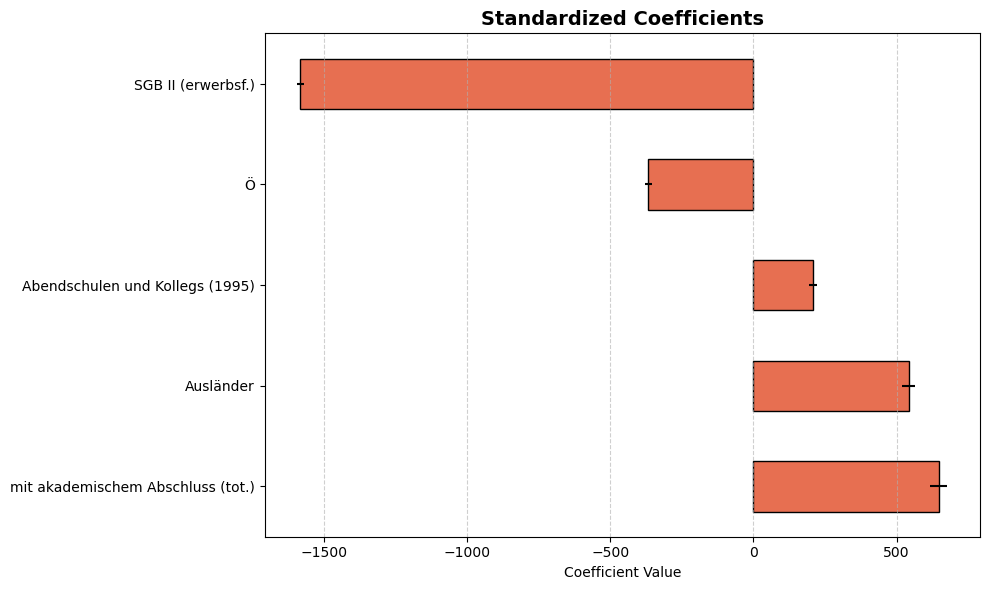

In [43]:
plt.figure(figsize=(10, 6))
coeffs_mean.plot(kind='barh', color=colors[4], edgecolor='black', xerr=coeffs_std)
plt.title('Standardized Coefficients', fontsize=14, fontweight='bold')
plt.xlabel('Coefficient Value')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Check MLR performance with different subsets

In [47]:
features_A = [
    'mit akademischem Abschluss (tot.)',
    'ohne Berufsabschluss (tot.)',
    'Beschäftigte (ausl.)',
    'SGB II (erwerbsf.)',
    'SGB XII (Grundsicher.)',
    'C',
    'G-J',
    'V',
    'Ö',
    'MSL (tot.)'
]
features_B = [
    'mit akademischem Abschluss (tot.)',
    'mit anerkanntem Berufsabschluss (tot.)',
    'ohne Berufsabschluss (tot.)',
    'SGB II (erwerbsf.)',
    'SGB II (n.erwerbsf.)',
    'SGB XII (Grundsicher.)',
    'Regelleist. (Asyl)',
    'Beschäftigte (tot.)'
]
features_C = [
    'Beschäftigte (tot.)',
    'Beschäftigte (ausl.)',
    'C',
    'B-E',
    'F',
    'G-J',
    'V',
    'Ö',
    'A'
]
features_D = [
    'Ausländer (w)',
    'Ausländer (m)',
    'mit akademischem Abschluss (ausl.)',
    'mit anerkanntem Berufsabschluss (ausl.)',
    'ohne Berufsabschluss (ausl.)',
    'Beschäftigte (ausl.)',
    'SGB II (erwerbsf.)'
]
features_E = [
    'mit akademischem Abschluss (tot.)',
    'SGB II (erwerbsf.)',
    'C',
    'Ö',
    'MSL (tot.)'
]
features_setlist = [features_A, features_B, features_C, features_D, features_E]


In [48]:
for selected_features in features_setlist:

    X = df_features[selected_features]
    y = df_target['Einkommen (adjusted)']



    X_scaled = StandardScaler().fit_transform(X)

    r2_list = []
    rmse_list = []
    coeff_list = []

    for seed in range(n_runs):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=seed
        )
        X_train = StandardScaler().fit_transform(X_train)
        X_test = StandardScaler().fit_transform(X_test)

        model = LinearRegression()

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        rmse = root_mean_squared_error(y_test, y_pred)
        r2_list.append(r2)
        rmse_list.append(rmse)

        coeffs = model.coef_ #pd.Series(model.coef_, index=X.columns)
        coeff_list.append(model.coef_)

    print("R² Score:", round(np.mean(np.array(r2_list)), 3), " +- ", round(np.std(np.array(r2_list)), 3))
    print("RMSE:", round(np.mean(np.array(rmse_list)), 2), " +- ", round(np.std(np.array(rmse_list)), 2))

print("\nIntercept:", round(model.intercept_, 2))
print("\nCoefficients:")
coeffs_mean = np.mean(np.array(coeff_list), axis=0)
coeffs_mean = pd.Series(coeffs_mean, index=X.columns)
coeffs_mean = coeffs_mean.sort_values(ascending=False)
with pd.option_context('display.max_rows', None):
    print(coeffs_mean)
# print([f"{coeffs.index[i]}: {int(coeffs.values[i])}" for i in range(len(coeffs))])

R² Score: 0.586  +-  0.025
RMSE: 1642.12  +-  87.26
R² Score: 0.595  +-  0.024
RMSE: 1625.34  +-  84.04
R² Score: 0.369  +-  0.026
RMSE: 2027.39  +-  81.92
R² Score: 0.609  +-  0.022
RMSE: 1595.94  +-  77.45
R² Score: 0.513  +-  0.028
RMSE: 1781.16  +-  90.84

Intercept: 22533.0

Coefficients:
MSL (tot.)                           1589.839928
mit akademischem Abschluss (tot.)     870.993543
C                                      94.944876
Ö                                    -418.229232
SGB II (erwerbsf.)                  -3020.366396
dtype: float64


# Overfitted RF classification (no hyperparameter tuning performed)

In [51]:
X = df_features.drop(columns=identifiers + Arbeitslose_keys)

y = df_target['Income category']

X_scaled = StandardScaler().fit_transform(X)

n_runs = 30
feature_ranks = pd.DataFrame(index=X.columns)
acc_list = []
train_acc_list = []
f1_macro_list = []
conf_matrices = []

for seed in range(n_runs):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=seed
    )

    X_train = StandardScaler().fit_transform(X_train)
    X_test = StandardScaler().fit_transform(X_test)

    # class_weights = {0: 4, 1: 1.0, 2: 1.0, 3: 9} 

    clf = RandomForestClassifier(n_estimators=120, random_state=seed)#,min_samples_leaf=40, max_depth=8, max_features="log2",class_weight=class_weights)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_train_pred = clf.predict(X_train)


    acc_list.append(accuracy_score(y_test, y_pred))
    train_acc_list.append(accuracy_score(y_train, y_train_pred))
    f1_macro_list.append(f1_score(y_test, y_pred, average='macro'))
    conf_matrices.append(confusion_matrix(y_test, y_pred))

    result = permutation_importance(clf, X_scaled, y, n_repeats=10, random_state=seed)
    importances = pd.Series(result.importances_mean, index=X.columns)
    ranks = importances.rank(ascending=False, method='min')
    feature_ranks[f'run_{seed}'] = ranks

feature_ranks['avg_rank'] = feature_ranks.mean(axis=1)
feature_ranks['std_rank'] = feature_ranks.std(axis=1)
rank_summary = feature_ranks.sort_values('avg_rank')

avg_conf_mat = np.mean(conf_matrices, axis=0)



=== Performance over 30 runs ===
Mean Accuracy:     0.897 ± 0.018
Mean Train Accuracy:     1.000 ± 0.000
Mean Macro F1:     0.829 ± 0.032

=== Average Confusion Matrix ===
[[ 27  11   0   0]
 [  3 331  18   0]
 [  0  29 319   1]
 [  0   1  17  23]]

=== STD of Confusion Matrix ===
[[ 4  4  0  0]
 [ 2 11  5  0]
 [ 0 13 18  1]
 [ 0  1  6  4]]

=== Top Features by Average Rank ===
                                                avg_rank  std_rank
SGB II (erwerbsf.)                              1.333333  0.745356
mit akademischem Abschluss (tot.)               2.633333  1.015983
SGB II (tot.)                                   3.433333  1.819951
MSL (tot.)                                      5.233333  2.499111
Ö                                               5.966667  2.880779
ohne Berufsabschluss (tot.)                     7.066667  2.839405
mit anerkanntem Berufsabschluss (tot.)          7.366667  2.549292
SGB XII (Grundsicher.)                          7.633333  3.240199
mit anerkanntem 

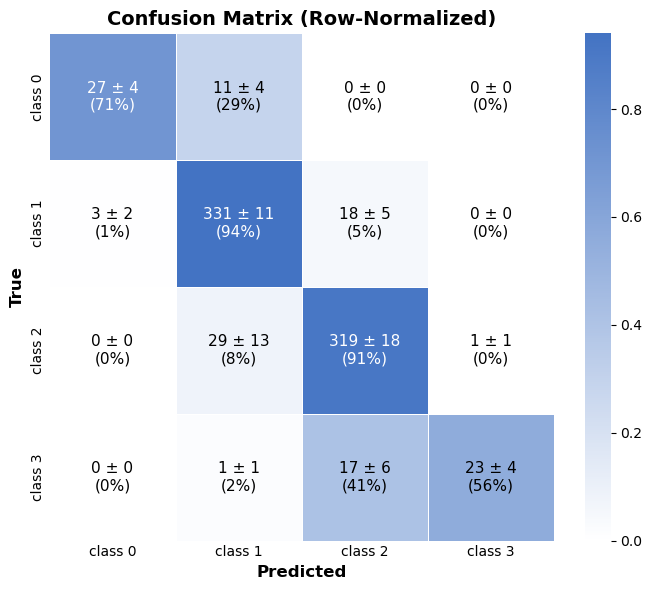

In [52]:
print("=== Performance over 30 runs ===")
print(f"Mean Accuracy:     {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}")
print(f"Mean Train Accuracy:     {np.mean(train_acc_list):.3f} ± {np.std(train_acc_list):.3f}")
print(f"Mean Macro F1:     {np.mean(f1_macro_list):.3f} ± {np.std(f1_macro_list):.3f}")

print("\n=== Average Confusion Matrix ===")
print(np.round(avg_conf_mat).astype(int))

std_conf_mat = np.std(conf_matrices, axis=0)
print("\n=== STD of Confusion Matrix ===")
print(np.round(std_conf_mat).astype(int))

print("\n=== Top Features by Average Rank ===")
print(rank_summary[['avg_rank', 'std_rank']])

class_names = ['Low', 'Medium low','Medium high', 'High']
class_names = ['Category 0', 'Category 1', 'Category 2', 'Category 3']
class_names = ["class "+str(i) for i in range(4)]

conf_matr = np.round(avg_conf_mat).astype(int)
conf_matr_std = np.round(std_conf_mat).astype(int)

blue_shade = "#4373c3"
custom_cmap = LinearSegmentedColormap.from_list("custom_blue", ["white", blue_shade])

row_sums = conf_matr.sum(axis=1, keepdims=True)
norm_conf = conf_matr / row_sums

plt.figure(figsize=(7, 6))
ax = sns.heatmap(norm_conf, annot=False, fmt='.2f', cmap=custom_cmap,
                 xticklabels=class_names, yticklabels=class_names,
                 cbar=True, linewidths=0.5)
ax.tick_params(axis='both', length=0)

for i in range(conf_matr.shape[0]):
    for j in range(conf_matr.shape[1]):
        count = conf_matr[i, j]
        std = conf_matr_std[i,j]
        perc = norm_conf[i, j] * 100
        text = f"{count} ± {std}\n({perc:.0f}%)"
        ax.text(j + 0.5, i + 0.5, text,
                ha='center', va='center',
                color='black' if perc < 60 else 'white',
                fontsize=11)

plt.xlabel('Predicted', fontsize=12, fontweight = "bold")
plt.ylabel('True', fontsize=12, fontweight = "bold")
plt.title('Confusion Matrix (Row-Normalized)', fontsize=14, fontweight = "bold")
plt.tight_layout()
plt.show()
